 * https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool
 * https://www.kaggle.com/jonathanbesomi/cord-19-sources-unification-with-pyspark-sql

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.ml.feature import CountVectorizer, Tokenizer
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql.functions import col, size

In [3]:
# spark = SparkSession.builder.appName("HW3-data-exploration").getOrCreate()
# Spark setup
conf = SparkConf().setMaster("local").setAppName("HW3-data-exploration")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Get all of the JSON files

In [4]:
root_path = '../data/archive/'
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
print("There are ", len(all_json), "sources files.")

There are  219713 sources files.


In [5]:
#todo - for now restrict this to 100 files
all_json = all_json[:100]

In [6]:
data = spark.read.json(all_json, multiLine=True)
data.createOrReplaceTempView("data")

In [7]:
data.limit(10).toPandas()

,back_matter,bib_entries,body_text,metadata,paper_id,ref_entries
0,[],"(([Row(first='KL', last='Banks', middle=[], su...","[([], [], Age and Breed ::: HISTORY ::: Diagno...","([(None, Dorothy, Ainsworth, ['M.'], ), (None,...",PMC7173479,((BOX 7-2: GRADING SCHEME FOR LYMPHOID HYPERPL...
1,[],"(([Row(first='R.K.', last='Abbott', middle=[],...","[([Row(end=410, mention='Beeler and van Wyke C...","([(None, Tara, Bancroft, [], ), (None, Blair, ...",PMC6780997,((Figure 1.: Identification and characterizati...
2,[],"(([Row(first='PJ', last='Barnes', middle=[], s...","[([], [], Casuïstiek ::: Inleiding, \n\nErnst...","([(None, C.D.A., Stehouwer, [], ), (None, R-P....",PMC7121426,"(None, None, None, None, None, None, None, Non..."
3,[],"(([Row(first='R.J.', last='Lefkowitz', middle=...","[([Row(end=15, mention='33', ref_id='BIBREF32'...","([(None, Einar, Krogsaeter, ['K.'], ), (None, ...",PMC7111325,((Fig. 1: CluePedia visualisation of proteins ...
4,[],"(([Row(first='F', last='Gao', middle=[], suffi...","[([Row(end=596, mention='9', ref_id='BIBREF180...","([(None, Edward, Janoff, ['N.'], ), (None, Phi...",PMC7094406,((Fig. 1: HIV-1 entry in the gastrointestinal ...
5,[],"(([Row(first='MB', last='Powell', middle=[], s...","[([Row(end=162, mention='1948', ref_id='BIBREF...","([(None, Abel, Lajtha, [], ), (None, Armen, Ga...",PMC7121640,"(None, None, None, None, None, None, None, Non..."
6,[],"(([Row(first='Z', last='Bai', middle=[], suffi...","[([Row(end=848, mention='1', ref_id='BIBREF0',...","([(None, Xiaolin, Fan, [], ), (None, Lei, Wang...",PMC7100848,((Figure 1: \nTime series of\n\documentclass[1...
7,[],"(([Row(first='J.F.', last='Cooley', middle=[],...","[([Row(end=156, mention='[1]', ref_id='BIBREF0...","([(None, Sara, Giannitelli, ['M.'], ), (None, ...",PMC7152487,((Figure 8.1: Number of publications on hybrid...
8,[],"(([Row(first='T.', last='Uchiyama', middle=[],...","[([Row(end=282, mention='1', ref_id='BIBREF0',...","([(None, Tiejun, Zhao, [], ), (None, Louis, Ma...",PMC4776189,((Figure 1: Regulatory and accessory genes enc...
9,[],"(([Row(first='A', last='Castello', middle=[], ...","[([Row(end=72, mention='1', ref_id='BIBREF0', ...","([(None, Nila, Choudhury, ['Roy'], ), (None, G...",PMC5678581,((Fig. 1: TRIM25 is a bona fide RNA-binding pr...


In [8]:
# Select text columns
covid_sql = spark.sql(
        """
        SELECT
            metadata.title AS title,
            body_text.text AS body_text,
            paper_id
        FROM data
        """)

In [9]:
covid_sql.limit(10).toPandas()

,title,body_text,paper_id
0,Disorders of the Respiratory System,[The age and breed of the animal exhibiting re...,PMC7173479
1,Detection and activation of HIV broadly neutra...,"[There are many pathogens, such as HIV-1, resp...",PMC6780997
2,16 Longziekten,[\n\nErnstige en soms fatale gevolgen van hoog...,PMC7121426
3,The protein interaction networks of mucolipins...,"[Cang et al. [33] found, in an effort to locat...",PMC7111325
4,Emerging concepts in gastrointestinal aspects ...,[New information on the infectiousness of HIV-...,PMC7094406
5,Autoimmune Processes in the Central Nervous Sy...,[The central nervous system (CNS) has been con...,PMC7121640
6,Global dynamics for a class of discrete SEIRS ...,"[As is well known, many infectious diseases po...",PMC7100848
7,Electrospinning and microfluidics,[The origin of electrospinning (ES) as a viabl...,PMC7152487
8,The Role of HBZ in HTLV-1-Induced Oncogenesis,[Human T-cell leukemia virus type 1 (HTLV-1) i...,PMC4776189
9,RNA-binding activity of TRIM25 is mediated by ...,[More than 300 novel RNA-binding proteins have...,PMC5678581


In [10]:
covid_sql.printSchema()

root
 |-- title: string (nullable = true)
 |-- body_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paper_id: string (nullable = true)



Now that we have the following:
  * title,
  * abstract,
  * body text,
  * back_matter

Join all of them

We definitely need to keep:
  * paper_id (as an index)
  * abstract
  * body text
  

Adding the Word Count Column

In [11]:
word_join_f = F.udf(lambda x: [''.join(w) for w in x], StringType())

In [12]:
# covid_sql = covid_sql.withColumn("abstract", word_join_f("abstract"))
covid_sql = covid_sql.withColumn("body_text", word_join_f("body_text"))

In [13]:
# see https://stackoverflow.com/questions/48927271/count-number-of-words-in-a-spark-dataframe
# df_with_wc = covid_sql.withColumn('wordCount_abstract', F.size(F.split(F.col('abstract'), ' ')))
df_with_wc = covid_sql.withColumn('wordCount_body_text', F.size(F.split(F.col('body_text'), ' ')))

df_with_wc.limit(10).toPandas()

,title,body_text,paper_id,wordCount_body_text
0,Disorders of the Respiratory System,[The age and breed of the animal exhibiting re...,PMC7173479,35361
1,Detection and activation of HIV broadly neutra...,"[There are many pathogens, such as HIV-1, resp...",PMC6780997,8370
2,16 Longziekten,[\n\nErnstige en soms fatale gevolgen van hoog...,PMC7121426,26694
3,The protein interaction networks of mucolipins...,"[Cang et al. [33] found, in an effort to locat...",PMC7111325,4533
4,Emerging concepts in gastrointestinal aspects ...,[New information on the infectiousness of HIV-...,PMC7094406,5805
5,Autoimmune Processes in the Central Nervous Sy...,[The central nervous system (CNS) has been con...,PMC7121640,7122
6,Global dynamics for a class of discrete SEIRS ...,"[As is well known, many infectious diseases po...",PMC7100848,5350
7,Electrospinning and microfluidics,[The origin of electrospinning (ES) as a viabl...,PMC7152487,3514
8,The Role of HBZ in HTLV-1-Induced Oncogenesis,[Human T-cell leukemia virus type 1 (HTLV-1) i...,PMC4776189,3326
9,RNA-binding activity of TRIM25 is mediated by ...,[More than 300 novel RNA-binding proteins have...,PMC5678581,6931


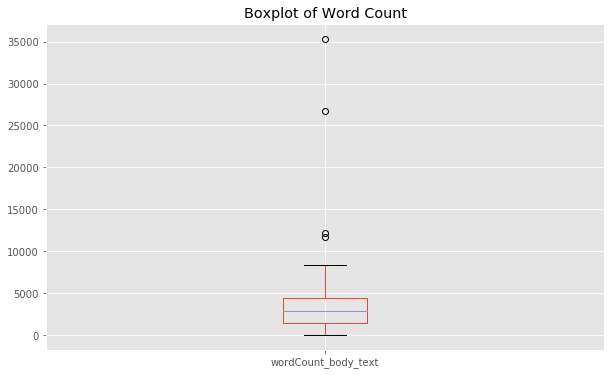

In [14]:
df_with_wc.limit(100).toPandas()[['wordCount_body_text']] \
        .plot(kind='box',
              title='Boxplot of Word Count',
              figsize=(10, 6))
plt.show()

In [15]:
# Tokenize the text in the text column
tokenizer = Tokenizer(inputCol="body_text", outputCol="words")
wordsDataFrame = tokenizer.transform(covid_sql)
wordsDataFrame.toPandas()

,title,body_text,paper_id,words
0,Disorders of the Respiratory System,[The age and breed of the animal exhibiting re...,PMC7173479,"[[the, age, and, breed, of, the, animal, exhib..."
1,Detection and activation of HIV broadly neutra...,"[There are many pathogens, such as HIV-1, resp...",PMC6780997,"[[there, are, many, pathogens,, such, as, hiv-..."
2,16 Longziekten,[\n\nErnstige en soms fatale gevolgen van hoog...,PMC7121426,"[[, , ernstige, en, soms, fatale, gevolgen, va..."
3,The protein interaction networks of mucolipins...,"[Cang et al. [33] found, in an effort to locat...",PMC7111325,"[[cang, et, al., [33], found,, in, an, effort,..."
4,Emerging concepts in gastrointestinal aspects ...,[New information on the infectiousness of HIV-...,PMC7094406,"[[new, information, on, the, infectiousness, o..."
...,...,...,...,...
95,Lung Ultrasound and the COVID‐19 “Pattern”: No...,[To the Editor: We read with great attention t...,PMC7272952,"[[to, the, editor:, we, read, with, great, att..."
96,A need for open public data standards and shar...,[The disjointed public health response to the ...,PMC7417174,"[[the, disjointed, public, health, response, t..."
97,Letter of response to comments on: Developing ...,[The authors declare that they have no known c...,PMC7474871,"[[the, authors, declare, that, they, have, no,..."
98,The impact of COVID-19 on the provision of don...,[The provision of donors for life-saving hemat...,PMC7091850,"[[the, provision, of, donors, for, life-saving..."


In [16]:
# Count vectorizer
cv_tmp = CountVectorizer(inputCol="words", outputCol="features")
cvmodel = cv_tmp.fit(wordsDataFrame)
df_vect = cvmodel.transform(wordsDataFrame)
df_vect.toPandas()

,title,body_text,paper_id,words,features
0,Disorders of the Respiratory System,[The age and breed of the animal exhibiting re...,PMC7173479,"[[the, age, and, breed, of, the, animal, exhib...","(20.0, 2391.0, 1692.0, 1152.0, 829.0, 682.0, 6..."
1,Detection and activation of HIV broadly neutra...,"[There are many pathogens, such as HIV-1, resp...",PMC6780997,"[[there, are, many, pathogens,, such, as, hiv-...","(0.0, 289.0, 230.0, 251.0, 148.0, 148.0, 93.0,..."
2,16 Longziekten,[\n\nErnstige en soms fatale gevolgen van hoog...,PMC7121426,"[[, , ernstige, en, soms, fatale, gevolgen, va...","(230.0, 0.0, 233.0, 0.0, 514.0, 0.0, 2.0, 420...."
3,The protein interaction networks of mucolipins...,"[Cang et al. [33] found, in an effort to locat...",PMC7111325,"[[cang, et, al., [33], found,, in, an, effort,...","(14.0, 189.0, 112.0, 151.0, 90.0, 62.0, 36.0, ..."
4,Emerging concepts in gastrointestinal aspects ...,[New information on the infectiousness of HIV-...,PMC7094406,"[[new, information, on, the, infectiousness, o...","(0.0, 311.0, 303.0, 220.0, 181.0, 108.0, 63.0,..."
...,...,...,...,...,...
95,Lung Ultrasound and the COVID‐19 “Pattern”: No...,[To the Editor: We read with great attention t...,PMC7272952,"[[to, the, editor:, we, read, with, great, att...","(0.0, 30.0, 12.0, 9.0, 10.0, 10.0, 4.0, 10.0, ..."
96,A need for open public data standards and shar...,[The disjointed public health response to the ...,PMC7417174,"[[the, disjointed, public, health, response, t...","(0.0, 37.0, 19.0, 29.0, 15.0, 15.0, 16.0, 7.0,..."
97,Letter of response to comments on: Developing ...,[The authors declare that they have no known c...,PMC7474871,"[[the, authors, declare, that, they, have, no,...","(0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
98,The impact of COVID-19 on the provision of don...,[The provision of donors for life-saving hemat...,PMC7091850,"[[the, provision, of, donors, for, life-saving...","(0.0, 22.0, 11.0, 16.0, 8.0, 16.0, 6.0, 7.0, 6..."


In [17]:
# todo - need to add id column here?
df_vect = df_vect.select("*").withColumn("id", monotonically_increasing_id())
df_vect.toPandas()

,title,body_text,paper_id,words,features,id
0,Disorders of the Respiratory System,[The age and breed of the animal exhibiting re...,PMC7173479,"[[the, age, and, breed, of, the, animal, exhib...","(20.0, 2391.0, 1692.0, 1152.0, 829.0, 682.0, 6...",0
1,Detection and activation of HIV broadly neutra...,"[There are many pathogens, such as HIV-1, resp...",PMC6780997,"[[there, are, many, pathogens,, such, as, hiv-...","(0.0, 289.0, 230.0, 251.0, 148.0, 148.0, 93.0,...",1
2,16 Longziekten,[\n\nErnstige en soms fatale gevolgen van hoog...,PMC7121426,"[[, , ernstige, en, soms, fatale, gevolgen, va...","(230.0, 0.0, 233.0, 0.0, 514.0, 0.0, 2.0, 420....",2
3,The protein interaction networks of mucolipins...,"[Cang et al. [33] found, in an effort to locat...",PMC7111325,"[[cang, et, al., [33], found,, in, an, effort,...","(14.0, 189.0, 112.0, 151.0, 90.0, 62.0, 36.0, ...",3
4,Emerging concepts in gastrointestinal aspects ...,[New information on the infectiousness of HIV-...,PMC7094406,"[[new, information, on, the, infectiousness, o...","(0.0, 311.0, 303.0, 220.0, 181.0, 108.0, 63.0,...",4
...,...,...,...,...,...,...
95,Lung Ultrasound and the COVID‐19 “Pattern”: No...,[To the Editor: We read with great attention t...,PMC7272952,"[[to, the, editor:, we, read, with, great, att...","(0.0, 30.0, 12.0, 9.0, 10.0, 10.0, 4.0, 10.0, ...",25769803776
96,A need for open public data standards and shar...,[The disjointed public health response to the ...,PMC7417174,"[[the, disjointed, public, health, response, t...","(0.0, 37.0, 19.0, 29.0, 15.0, 15.0, 16.0, 7.0,...",25769803777
97,Letter of response to comments on: Developing ...,[The authors declare that they have no known c...,PMC7474871,"[[the, authors, declare, that, they, have, no,...","(0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",25769803778
98,The impact of COVID-19 on the provision of don...,[The provision of donors for life-saving hemat...,PMC7091850,"[[the, provision, of, donors, for, life-saving...","(0.0, 22.0, 11.0, 16.0, 8.0, 16.0, 6.0, 7.0, 6...",25769803779


In [18]:
num_topics = 10
max_iterations = 50
lda = LDA(seed=1, optimizer="em", k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(df_vect)

In [37]:
# Analyze Topic Distributions
# topics = lda_model.describeTopics(maxTermsPerTopic=15).toPandas()
# for x, topic in enumerate(topics):
#     print('topic nr: ' + str(x))
#     words = topic[0]
#     weights = topic[1]
#     for n in range(15):
#         print(cvmodel.vocabulary[words[n]] + ' ' + str(weights[n]))
topics = lda_model.topicsMatrix()
vocabArray = cvmodel.vocabulary

wordNumbers = 15  # number of words per topic
topicIndices = sc.parallelize(lda_model.describeTopics(maxTermsPerTopic = wordNumbers))


def topic_render(topic):  # specify vector id of words to actual words
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()

# for topic in range(len(topics_final)):
#     print ("Topic" + str(topic) + ":")
#     for term in topics_final[topic]:
#         print (term)
#     print ('\n')

TypeError: can't pickle _thread.RLock objects

In [32]:
topicIndices.collect()

[[0,
  [10, 14, 18, 25, 26, 4, 38, 40, 7, 69, 82, 2, 88, 95, 96],
  [0.06466690224433636,
   0.04415813670838541,
   0.03905523630664414,
   0.024849053577843904,
   0.024262239607109024,
   0.019550248652444712,
   0.017651209260524128,
   0.016598218165432766,
   0.015235018617470075,
   0.009677971328504944,
   0.008713017824496147,
   0.008238069856115969,
   0.008138308414131276,
   0.007658300553771917,
   0.007636481469753958]],
 [1,
  [1, 2, 3, 4, 5, 6, 16, 13, 8, 11, 15, 9, 7, 12, 113],
  [0.052652438781636654,
   0.03578824063311669,
   0.03338658073714968,
   0.02509136275423874,
   0.017654567117103347,
   0.012843085772044066,
   0.012239966836577973,
   0.0118256163243502,
   0.011702928987867397,
   0.009227735300356123,
   0.00901519601086035,
   0.008907788232802454,
   0.005601797815341013,
   0.005070816367470901,
   0.004523465372892838]],
 [2,
  [1, 2, 3, 4, 5, 6, 9, 8, 7, 11, 12, 34, 16, 15, 13],
  [0.04532944520319436,
   0.03072131575982452,
   0.030448210531859